In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [2]:
from kpm_linreg import *
from bong.src import bbb, blr, bog, bong, experiment_utils
from bong.util import run_rebayes_algorithm, tune_init_hyperparam

print(AGENT_TYPES)


['fg-bong', 'fg-l-bong', 'fg-rep-bong', 'fg-rep-l-bong', 'fg-blr', 'fg-bog', 'fg-rep-bog', 'fg-bbb', 'fg-rep-bbb']


In [3]:

#python  bong/experiments/kpm_linreg.py  --debug True
#python  bong/experiments/kpm_linreg.py  --agents fg-bong fg-bog --num_samples 100

parser = argparse.ArgumentParser()
    
  # Data parameters
parser.add_argument("--num_examples", type=int, default=500)
parser.add_argument("--param_dim", type=int, default=10)
parser.add_argument("--key", type=int, default=0)
parser.add_argument("--emission_noise", type=float, default=1.0)

# Model parameters
parser.add_argument("--agents", type=str, nargs="+",
                    default=["fg-bong",  "fg-bog"], choices=AGENT_TYPES)
parser.add_argument("--num_samples", type=int, nargs="+", 
                    default=[100])
parser.add_argument("--learning_rate", type=int, nargs="+", 
                    default=[0.001, 0.005, 0.01, 0.05])
parser.add_argument("--tune_learning_rate", type=bool, default=False)

#https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook
#args = parser.parse_args()
args = parser.parse_args(args=[])
print(args)

#main(args)#


Namespace(num_examples=500, param_dim=10, key=0, emission_noise=1.0, agents=['fg-bong', 'fg-bog'], num_samples=[100], learning_rate=[0.005, 0.01, 0.05], tune_learning_rate=False)


Running fg-bong-MC100...
	KL-Div: 0.0172, Time: 0.52s
Running fg-bog-MC100-LR0_005...
	KL-Div: 16.3959, Time: 0.45s
Running fg-bog-MC100-LR0_01...
	KL-Div: 15.1866, Time: 0.46s
Running fg-bog-MC100-LR0_05...
	KL-Div: nan, Time: 0.44s


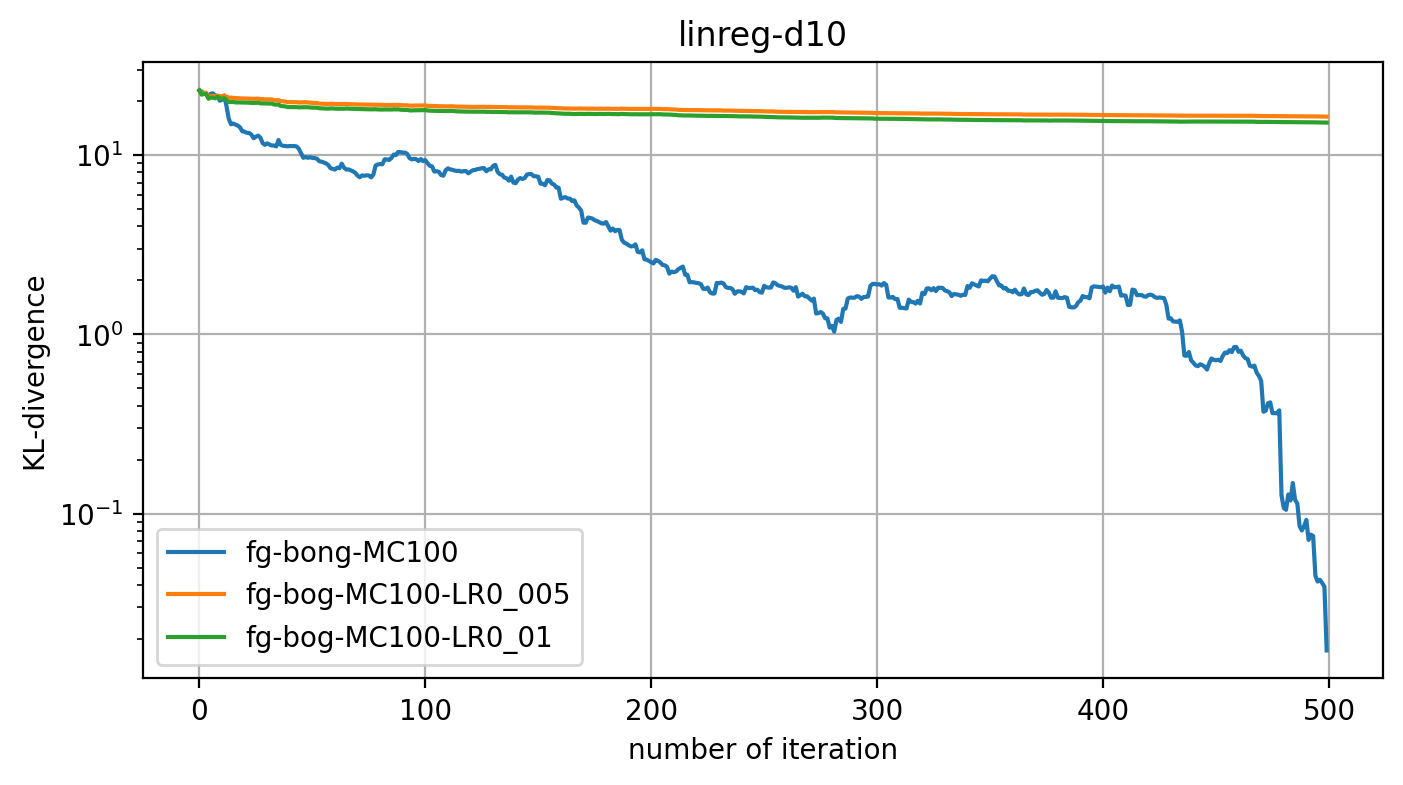

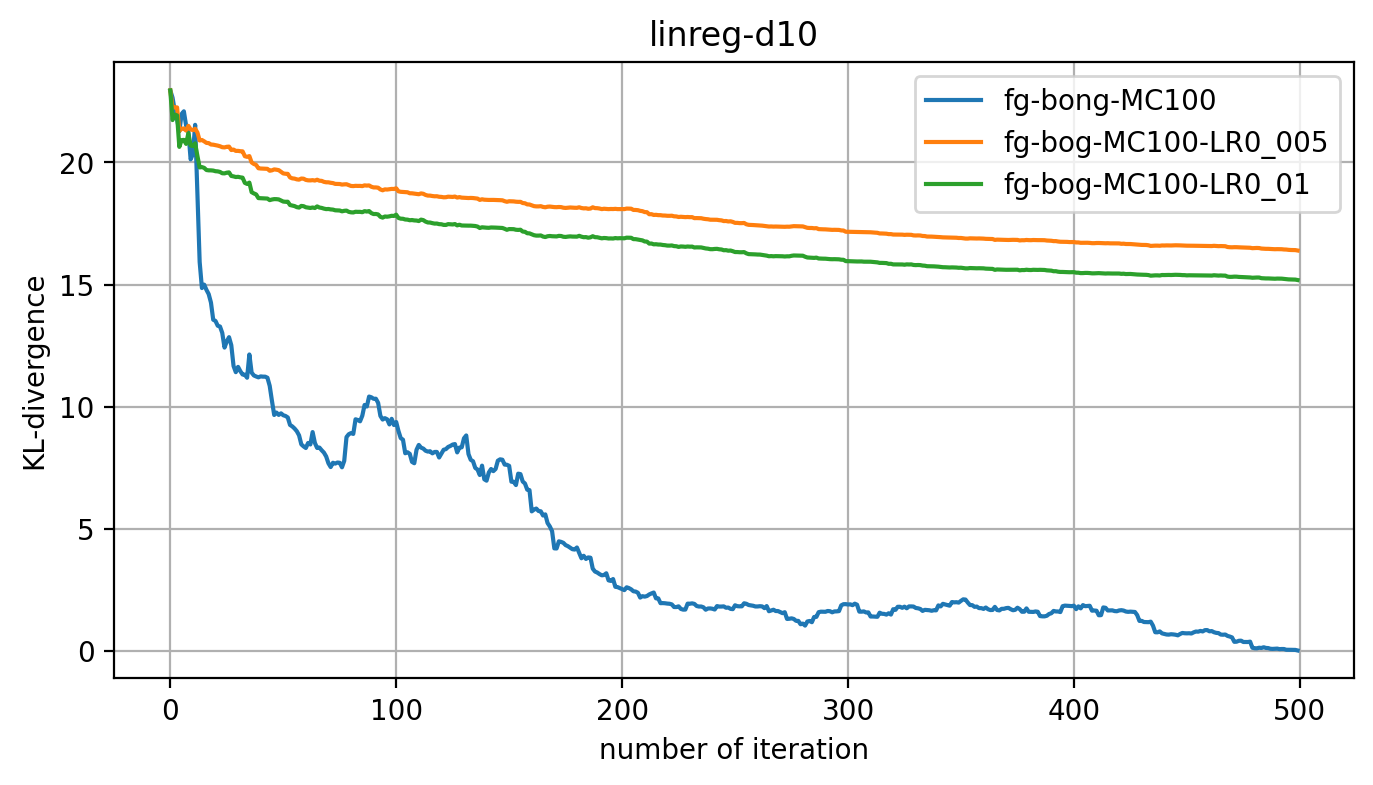

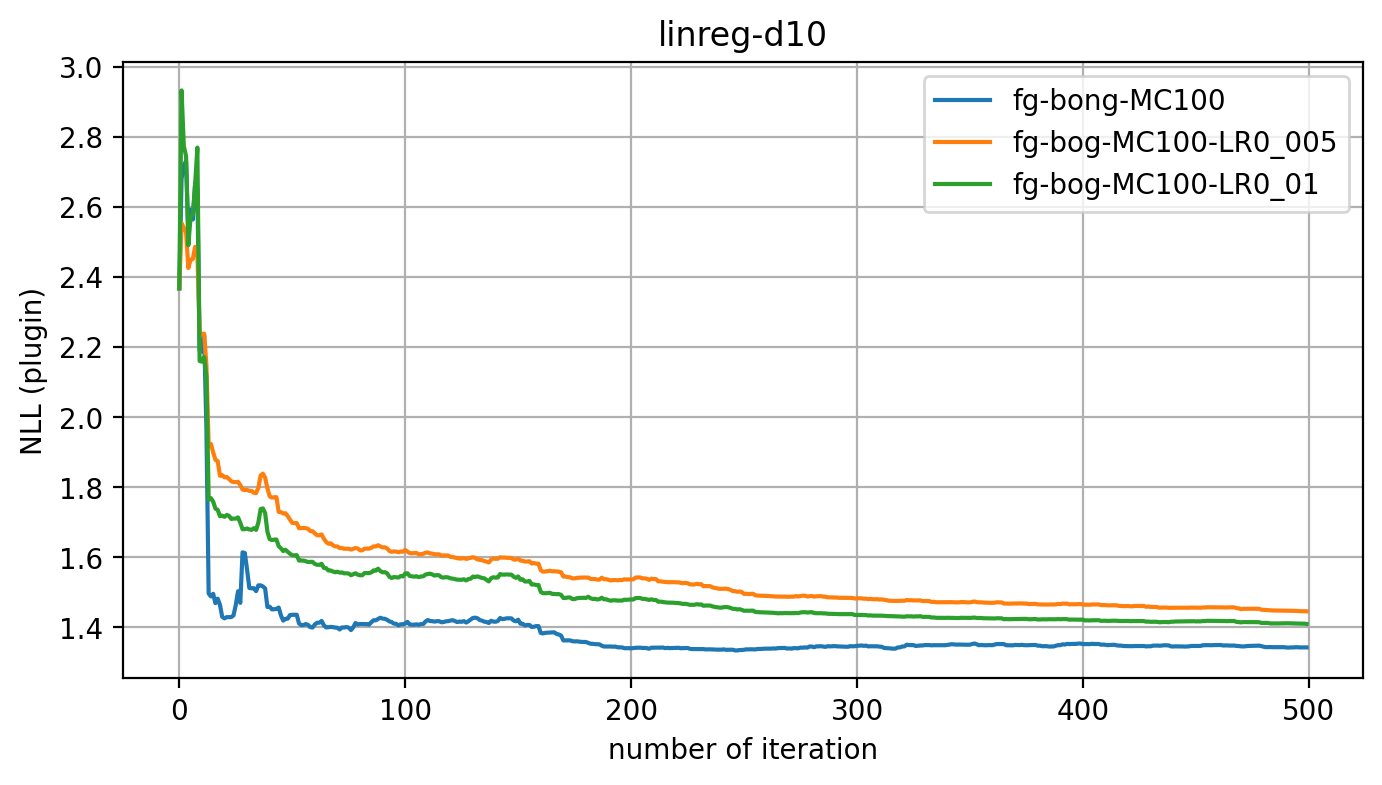

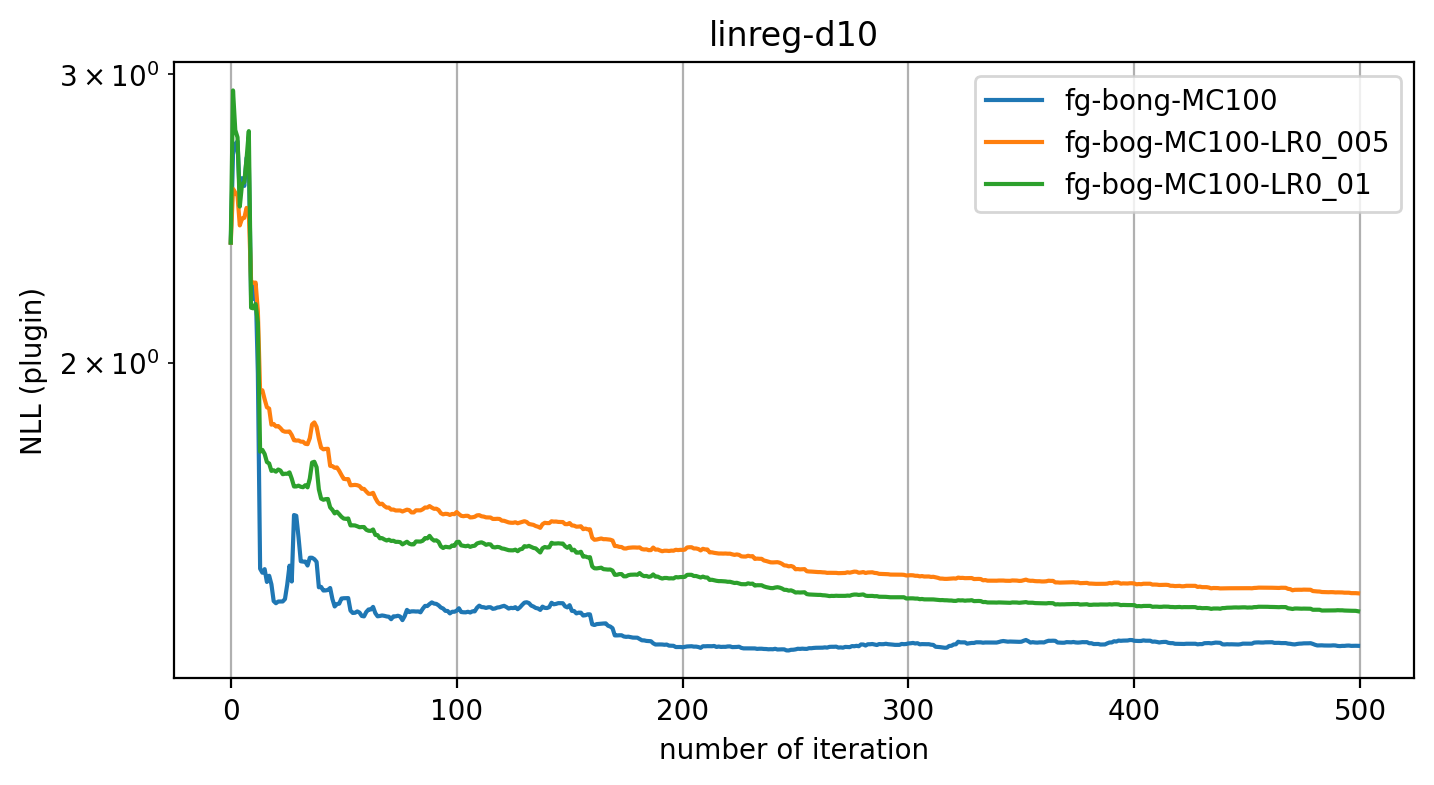

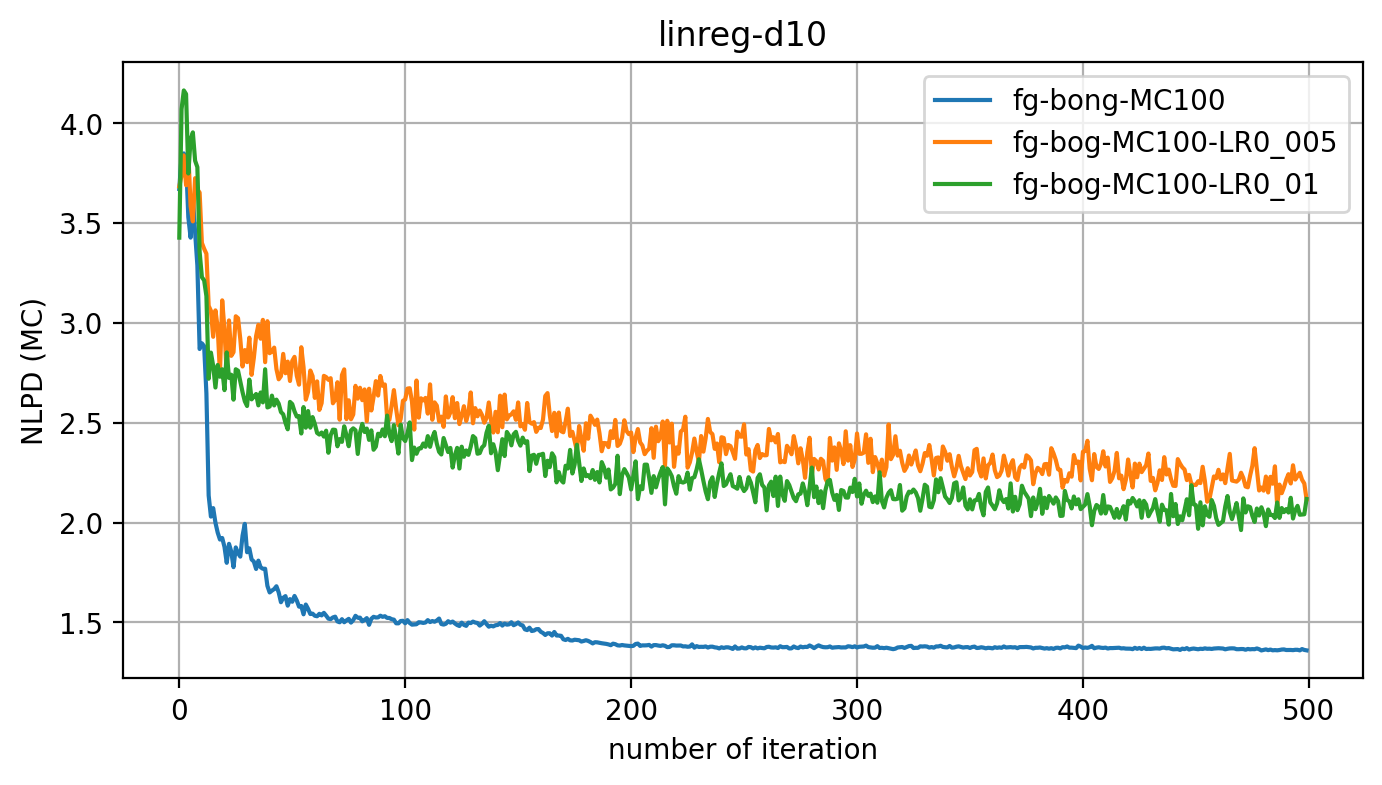

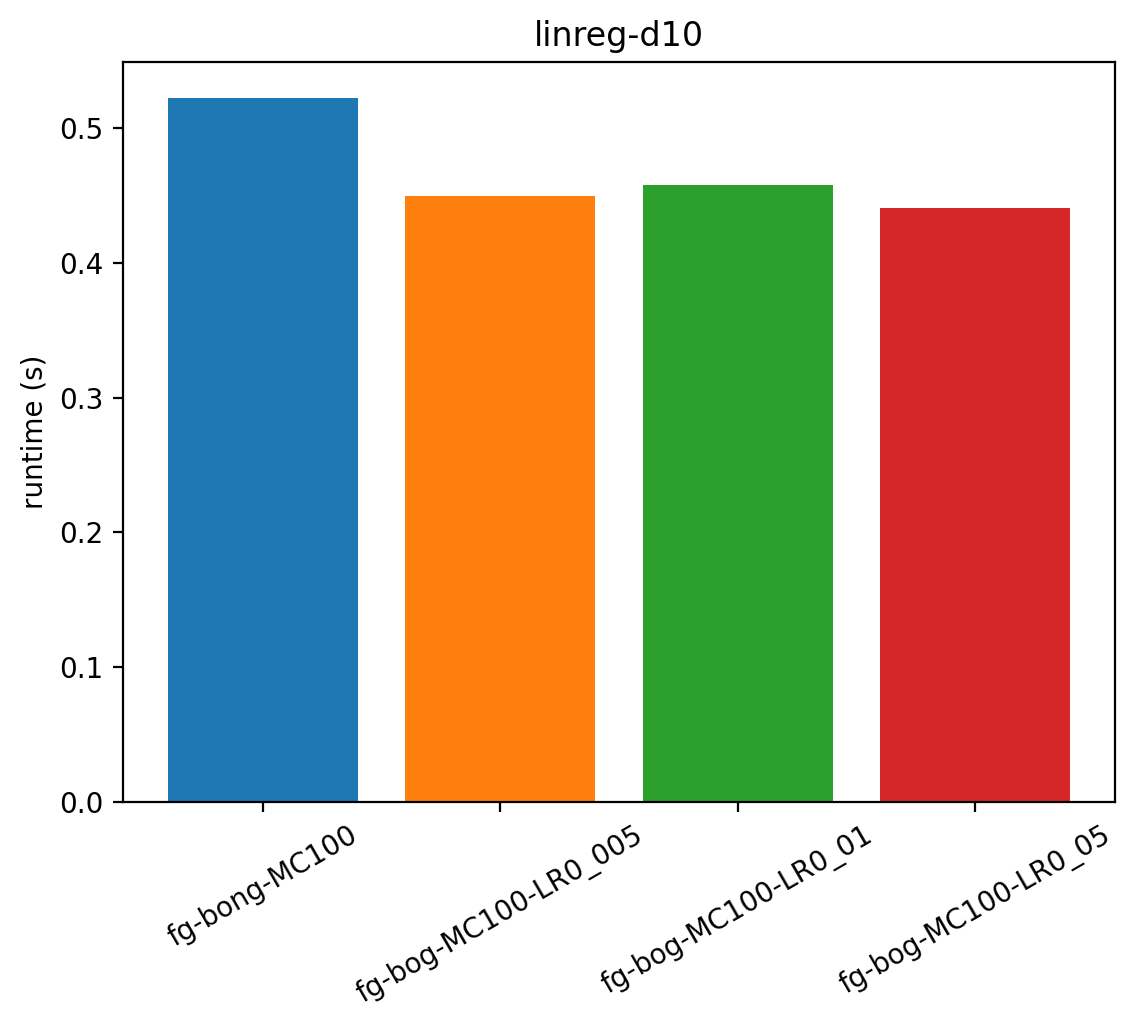

In [4]:
data, subkey = make_data(args)
init_kwargs, callback = init(args, data)
prior, post = compute_prior_post(args, data)
 

agent_queue, subkey = make_agent_queue(subkey, args, init_kwargs, None, data['X_tr'], data['Y_tr'])
result_dict = run_agents(subkey, agent_queue, data, callback)
  
ttl = f"linreg-d{args.param_dim}"
curr_path = None
plot_results(result_dict, curr_path, ttl)
